# Data Preprocessing

The data we currently have was found on Kaggle. It is a very well known labeled music genre dataset. However, it is split into two distinct sections, raw audio files and mel spectograms. While having ready made melspectoggrams could be useful, we decided we wanted to generate our own mel-spectograms from the raw audio, so we could better manipulate it to fit our needs.

We are going to perform the following:
- Generate Mel-spectograms from audio files
- Play around with the MFCCs to see which amount is most useful for our data
- Normalization is applied during MFCC extraction

Optional data augmentation techniques we may use:
- Time Inversion (Flipping the Audio/Spectrogram): Flipping provides additional patterns that strengthen the model's ability to detect genre-specific elements regardless of their exact placement.
- Random Cropping: takes different parts of the audio sample each time, so the model learns to identify genre features from various portions of a song.




### Step 0: Unzip Data

1. Upload Zip File Data_fixed.zip (might take a while)
2. run: ```unzip Data.zip -d ./Data```
3. if it doesn't work run: ```zip -FF Data.zip --out Data_fixed.zip```
4. then, ```unzip Data_fixed.zip -d ./Data```





### Step 1: Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import scipy
import os
import json
import math

### Step 2: Define Helper Functions

**Waveform Plotting Function**
- Purpose: To plot the waveform of an audio signal.
- Parameters:
  - audio: The audio time series data.
  - sr: The sampling rate of the audio.
- Uses librosa.display.waveshow: A function to display waveforms.
- Visualization: Helps in understanding the time-domain characteristics of the audio signal, such as amplitude variations over time.

In [2]:
def plot_waveform(audio, sr):
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(audio, sr=sr)
    plt.title('Waveform')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

**Spectrogram Calculation and Plotting Functions**
- Purpose: To compute and plot the spectrogram of an audio signal.
- Parameters:
  - n_fft: Number of samples in each Fourier Transform window (controls frequency resolution).
  - hop_length: Number of samples between successive frames (controls time resolution).
- Uses Short-Time Fourier Transform (stft): Decomposes the signal into its frequency components over time.
- Converts amplitude to decibels (amplitude_to_db): For better visualization of the spectrogram.
- Visualization: The spectrogram shows how the frequency content of the signal changes over time, which is essential for understanding the spectral characteristics of audio.


- Purpose: To compute and plot the Mel-spectrogram of an audio signal.
- Mel-Spectrogram: Represents the short-term power spectrum of the audio signal on a Mel scale, which aligns more closely with human auditory perception.
- Parameters:
  - n_mels: Number of Mel bands to generate.
- Visualization: Useful for feature extraction in tasks like music genre classification because it captures perceptually relevant frequency information.

In [3]:
def plot_spectrogram(audio, sr, n_fft=2048, hop_length=512):
    stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    stft_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

    plt.figure(figsize=(12, 4))
    librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='log', hop_length=hop_length, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()
    plt.show()

def plot_mel_spectrogram(audio, sr, n_mels=128, n_fft=2048, hop_length=512):
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    plt.figure(figsize=(12, 4))
    librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel', hop_length=hop_length, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-Spectrogram')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Mel Frequency')
    plt.tight_layout()
    plt.show()


**MFCC Calculation and Plotting Functions**
- Purpose: To extract Mel-frequency cepstral coefficients (MFCCs) from the audio signal.
- MFCCs: Compact representations of the spectral envelope of the audio signal, widely used in audio and speech processing for their ability to represent timbral aspects.
- Parameters:
  - n_mfcc: Number of MFCCs to extract (13 is standard).
- Justification: MFCCs are effective features for genre classification because they capture the essential characteristics of the audio's timbre.

In [4]:
def extract_mfccs(audio, sr, n_mfcc=13, n_fft=2048, hop_length=512):
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    return mfccs

def plot_mfccs(mfccs, sr, hop_length=512):
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(mfccs, x_axis='time', sr=sr, hop_length=hop_length, cmap='viridis')
    plt.colorbar()
    plt.title('MFCCs')
    plt.xlabel('Time (seconds)')
    plt.ylabel('MFCC Coefficient')
    plt.tight_layout()
    plt.show()

### Step 3: Set Parameters
- SAMPLE_RATE: Set to 22,050 Hz, a common sampling rate for audio processing that balances quality and computational efficiency.
- DURATION: 30 seconds, assuming that each audio file is 30 seconds long.
SAMPLES_PER_TRACK: Total number of samples per track (sample rate * duration).
- MFCC Parameters:
  - N_MFCC: Number of MFCCs to extract (13 is standard in speech processing).
  - N_FFT: Number of samples in each FFT window.
  - HOP_LENGTH: Number of samples between successive frames.
- Paths:
  - DATASET_PATH: Directory containing the audio files.
  - JSON_PATH: Path to save the extracted features in JSON format.
- Justification:

  - Setting consistent parameters ensures that all audio files are processed uniformly, which is crucial for model training.
  - The MFCC parameters are chosen to capture relevant audio features without excessive computational load.

In [5]:
SAMPLE_RATE = 22050
DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
N_MFCC = 13
N_FFT = 2048
HOP_LENGTH = 512
DATASET_PATH = "data/genres"
JSON_PATH = "data.json"

###Step 4: Segment Audio Files
- Purpose: To divide each audio file into smaller segments.
- NUM_SEGMENTS: Splitting each 30-second track into 3 segments of 10 seconds each.
- Why Segment?:
  - Data Augmentation: Increases the number of training samples.
  - Model Generalization: Helps the model learn from different parts of the track.
- Calculations:
  - SAMPLES_PER_SEGMENT: Number of samples in each segment.
  - EXPECTED_NUM_MFCC_VECTORS: Number of MFCC vectors expected per segment (used for validation).



In [6]:
NUM_SEGMENTS = 3
SAMPLES_PER_SEGMENT = int(SAMPLES_PER_TRACK / NUM_SEGMENTS)
EXPECTED_NUM_MFCC_VECTORS = math.ceil(SAMPLES_PER_SEGMENT / HOP_LENGTH)

### Step 5: Process Audio Files and Extract MFCCs
- Purpose: To process all audio files in the dataset, extract MFCCs from each segment, and save the data into a JSON file.
- Data Structure:
  - data["mapping"]: List of genre labels (e.g., 'blues', 'classical').
  - data["labels"]: Numeric labels corresponding to each genre (used for modeling).
  - data["mfcc"]: List of MFCC arrays for each segment.
- Processing Steps:
  - Directory Traversal: Using os.walk to iterate over each genre directory and its files.
  - Genre Label Extraction: Using os.path.basename to get the genre name from the directory path.
- File Processing:
  - File Check: Ensuring the file is a .wav audio file.
  - Audio Loading: Using librosa.load with a consistent SAMPLE_RATE.
  - Length Check: Ensuring the audio file is at least as long as the expected duration.
- Segment Processing:
  - Segment Boundaries: Calculating start and finish indices for each segment.
  - MFCC Extraction: Extracting MFCCs for each segment.
  - Transposing MFCCs: Transposing so that time frames are along the first dimension.
  - Validation: Checking if the extracted MFCCs have the expected number of vectors (to ensure consistency).
  - Data Appending: Adding the MFCCs and labels to the data dictionary.
- Error Handling:
  - Try-Except Block: To catch and report any errors during file processing.
  - File Skipping: Skips files that are shorter than expected or not audio files.
- Justification:

  - Consistency: Ensuring all segments have the same shape is crucial for training a neural network.
  - Data Integrity: By checking the length of MFCCs, we prevent inconsistencies that could cause errors during modeling.
  - Labeling: Numeric labels are necessary for training classification models.

In [7]:
def save_mfcc(dataset_path, json_path, num_segments=NUM_SEGMENTS):
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_track = SAMPLE_RATE * DURATION
    samples_per_segment = int(samples_per_track / num_segments)
    expected_num_mfcc_vectors = math.ceil(samples_per_segment / HOP_LENGTH)

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath != dataset_path:
            genre_label = os.path.basename(dirpath)
            data["mapping"].append(genre_label)
            print(f"\nProcessing Genre: {genre_label}")

            for f in filenames:
                if f.endswith('.wav') or f.endswith('.au'):
                    file_path = os.path.join(dirpath, f)
                    try:
                        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

                        if len(signal) >= samples_per_track:
                            for s in range(num_segments):
                                start = samples_per_segment * s
                                finish = start + samples_per_segment

                                mfccs = librosa.feature.mfcc(
                                    y=signal[start:finish],
                                    sr=sr,
                                    n_mfcc=N_MFCC,
                                    n_fft=N_FFT,
                                    hop_length=HOP_LENGTH
                                )
                                mfccs = mfccs.T

                                if len(mfccs) == expected_num_mfcc_vectors:
                                    data["mfcc"].append(mfccs.tolist())
                                    data["labels"].append(i - 1)
                                else:
                                    print(f"Segment {s} of file {f} has unexpected length {len(mfccs)}")
                        else:
                            print(f"File {f} is shorter than expected. Skipping.")
                    except Exception as e:
                        print(f"Error processing file {file_path}: {e}")
                else:
                    print(f"Skipping non-audio file: {f}")

    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

    print("\nData processing complete and saved to", json_path)


Run save_mfcc


Executes the save_mfcc function to process the entire dataset and save the extracted features and labels to data.json.



In [8]:
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=NUM_SEGMENTS)



Processing Genre: blues

Processing Genre: classical
File classical.00049.au is shorter than expected. Skipping.
File classical.00051.au is shorter than expected. Skipping.

Processing Genre: country
File country.00003.au is shorter than expected. Skipping.
File country.00004.au is shorter than expected. Skipping.
File country.00007.au is shorter than expected. Skipping.

Processing Genre: disco
File disco.00014.au is shorter than expected. Skipping.

Processing Genre: hiphop
File hiphop.00031.au is shorter than expected. Skipping.
File hiphop.00032.au is shorter than expected. Skipping.

Processing Genre: jazz

Processing Genre: metal

Processing Genre: pop

Processing Genre: reggae

Processing Genre: rock
File rock.00038.au is shorter than expected. Skipping.

Data processing complete and saved to data.json


### Step 6: Load and Inspect Processed Data
- Purpose: To load the processed data and verify its contents.
- Print Statements:
  - Number of Samples: Should match the total number of segments processed.
  - Number of Labels: Should be equal to the number of samples.
  - Mapping: Displays the genre labels.
  - MFCC Shape: Checks the shape of the MFCC array for one sample to ensure it matches expectations.


In [9]:
with open(JSON_PATH, "r") as fp:
    data = json.load(fp)

print(f"Number of samples: {len(data['mfcc'])}")
print(f"Number of labels: {len(data['labels'])}")
print(f"Mapping: {data['mapping']}")

print(f"MFCC shape for one sample: {np.array(data['mfcc'][0]).shape}")

Number of samples: 2973
Number of labels: 2973
Mapping: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
MFCC shape for one sample: (431, 13)


### Step 7: Prepare Data for Modeling

- Convert Lists to NumPy Arrays: For efficient computation and compatibility with machine learning models.
- Add a Channel Dimension: X = X[..., np.newaxis] adds an extra dimension to represent channels (required for convolutional neural networks).
- Data Splitting:
  - Training Set: 80% of the data.
  - Temporary Set (X_temp, y_temp): Remaining 20%, which will be split into validation and test sets.
  - Validation and Test Sets: Each gets 50% of the temporary set, resulting in 10% of the total data each.
- Why Split Data?:
  - Training Set: Used to train the model.
  - Validation Set: Used to tune hyperparameters and prevent overfitting.
  - Test Set: Used to evaluate the final model performance.
- Random State: Ensures reproducibility of the splits.




In [10]:
X = np.array(data['mfcc'])
y = np.array(data['labels'])

X = X[..., np.newaxis]

from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_validation.shape}, {y_validation.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")


Training set: (2378, 431, 13, 1), (2378,)
Validation set: (297, 431, 13, 1), (297,)
Test set: (298, 431, 13, 1), (298,)


### Step 8: Implement Data Augmentation (Flipping the MFCCs)

- Purpose: To augment the training data by flipping the MFCCs along the time axis.
- Flipping MFCCs:
  - np.flip: Flips the array along the specified axis (axis=1 corresponds to time frames).
  - Rationale: Time inversion introduces variations in the data, helping the model generalize better.
- Data Concatenation:
  - Original and Flipped Data: Combined to create an augmented dataset that is double the size of the original training set.
- Label Copy: The labels remain the same since flipping does not change the genre of the audio.


In [11]:
X_train_flipped = np.flip(X_train, axis=1)
y_train_flipped = y_train.copy()

X_train_augmented = np.concatenate((X_train, X_train_flipped), axis=0)
y_train_augmented = np.concatenate((y_train, y_train_flipped), axis=0)

print(f"Augmented training set: {X_train_augmented.shape}, {y_train_augmented.shape}")


Augmented training set: (4756, 431, 13, 1), (4756,)


### Step 9: Save Preprocessed Data (Optional)


In [12]:
np.save('X_train_augmented.npy', X_train_augmented)
np.save('y_train_augmented.npy', y_train_augmented)
np.save('X_validation.npy', X_validation)
np.save('y_validation.npy', y_validation)
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

### Step 10: Load Preprocessed Data (When Needed)


In [13]:
X_train_augmented = np.load('X_train_augmented.npy')
y_train_augmented = np.load('y_train_augmented.npy')
X_validation = np.load('X_validation.npy')
y_validation = np.load('y_validation.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')


## Visualization

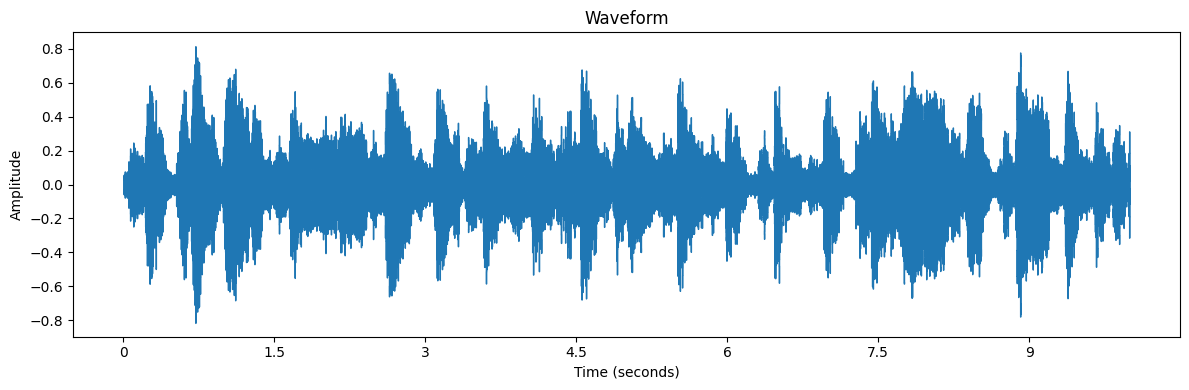

In [19]:
file_path = 'data/genres/blues/blues.00000.au'
signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

padding = SAMPLES_PER_SEGMENT - len(signal)

if padding > 0:
    audio_segment = np.pad(signal, (0, padding), mode='constant')
elif padding < 0:
    audio_segment = signal[:SAMPLES_PER_SEGMENT]
else:
    audio_segment = signal

plot_waveform(audio_segment, sr)


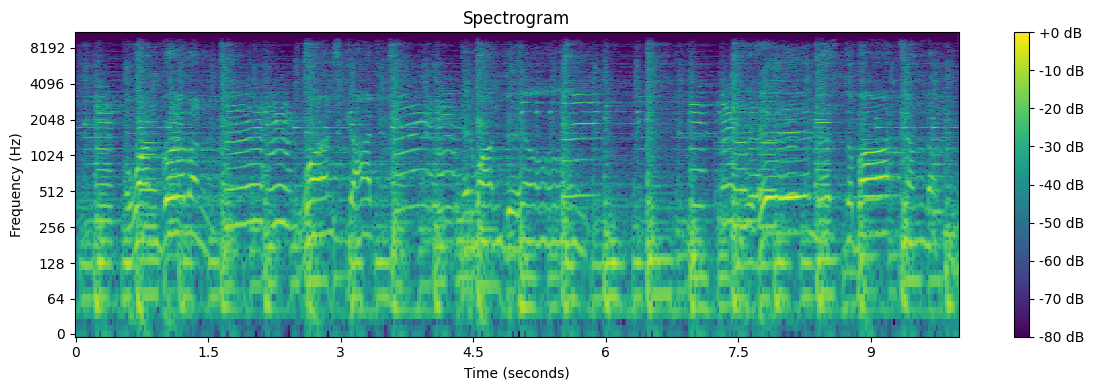

In [20]:
plot_spectrogram(audio_segment, sr)

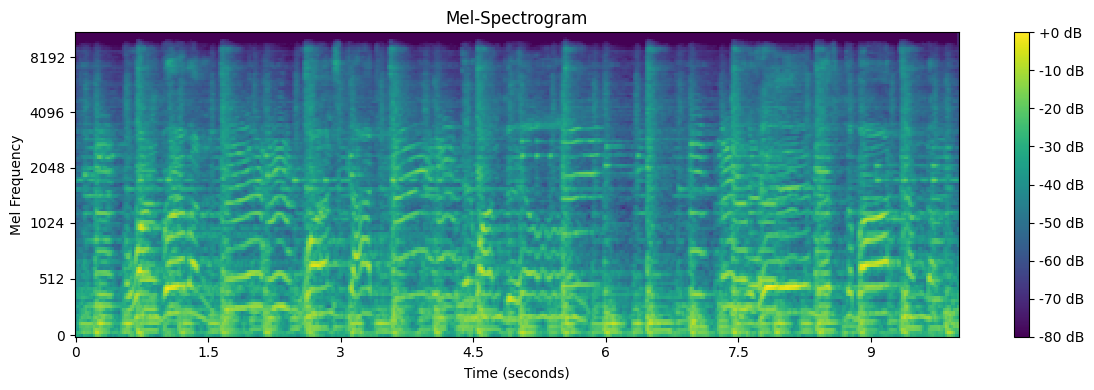

In [21]:
plot_mel_spectrogram(audio_segment, sr)


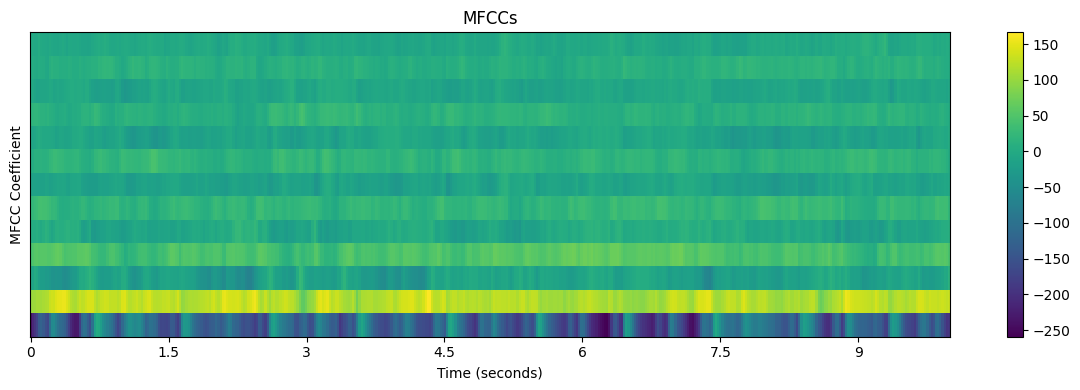

In [22]:
mfccs = extract_mfccs(audio_segment, sr)
plot_mfccs(mfccs, sr)


# Next Steps:
1. Download:
    - Training Data:

        - X_train_augmented.npy — Augmented training features.
        - y_train_augmented.npy — Labels for the augmented training data.
    - Validation Data:

        - X_validation.npy — Validation features.
        - y_validation.npy — Labels for the validation data.
    - Test Data:

        - X_test.npy — Test features.
        - y_test.npy — Labels for the test data.
2. Run Model training and testing Notebook


In [23]:
import zipfile
import os
def zip_npy_files(source_dir, zip_filename):
    """
    Compresses all .npy files in the specified directory into a ZIP file.

    Parameters:
        source_dir (str): The directory containing .npy files to compress.
        zip_filename (str): The name of the output ZIP file.
    """
    # Create a ZipFile object in write mode
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Iterate over all files in the source directory
        for root, dirs, files in os.walk(source_dir):
            for file in files:
                if file.endswith('.npy'):
                    # Create complete file path
                    file_path = os.path.join(root, file)
                    # Add file to the ZIP archive
                    zipf.write(file_path, arcname=file)
                    print(f"Added {file} to {zip_filename}")
    print(f"\nAll .npy files have been zipped into {zip_filename}")

# Example usage:
source_directory = './'  # Replace with the path to your .npy files
zip_file_name = 'npy_files.zip'             # Desired name for the ZIP file

zip_npy_files(source_directory, zip_file_name)

Added X_test.npy to npy_files.zip
Added X_train_augmented.npy to npy_files.zip
Added X_validation.npy to npy_files.zip
Added y_test.npy to npy_files.zip
Added y_train_augmented.npy to npy_files.zip
Added y_validation.npy to npy_files.zip

All .npy files have been zipped into npy_files.zip


#How can this be improved for further studies?

When we split the data into train, test, and validation, we are randomly taking a percentage from the 10 second segments. This could be a concern, since some testing and training data will be different segments of the same song. Anyone trying to improve this study may decide to split the training and testing data before segmenting the audio files.